# Step 2 - Feature enginering

This is a study case to use regression algorithm to predict 1 minute forex price movement.
In this step extract MACD and RSI indicator as feature data.

Step 1. [Data exploration](/notebooks/forex/mark1/1_data_explore.ipynb)

Step 2. **Feature engineering**

Step 3. [Data training and models evaluation](/notebooks/forex/mark1/3_training_and_optimazation.ipynb)

# import

In [2]:
from math import sqrt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import talib as ta

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

csv_path = 'data/GBPUSD_Candlestick_1_M_ASK_01.02.2018-01.02.2019_cleaned.csv'
test_csv_path = 'data/GBPUSD_Candlestick_1_M_ASK_01.02.2019-24.04.2019_cleaned.csv'

# Load cleaned data

In [3]:
# load csv
df = pd.read_csv(csv_path,
                 header=0,
                 names=['time', 'open', 'high', 'low', 'close', 'volume', 
                        'hour', 'volatility'],
                 parse_dates=['time'])
df = df.set_index('time')
print('Row count = %d' % len(df))

test_df = pd.read_csv(test_csv_path,
                 header=0,
                 names=['time', 'open', 'high', 'low', 'close', 'volume'],
                 parse_dates=['time'])
test_df = test_df.set_index('time')
print('Row count = %d' % len(test_df))

df.head(5)

Row count = 374596
Row count = 83523


,open,high,low,close,volume,hour,volatility
time,,,,,,,
2018-02-01 00:00:00,1.41996,1.42005,1.41994,1.42005,81.63,0,1.1
2018-02-01 00:01:00,1.42008,1.42014,1.41993,1.41997,130.89,0,2.1
2018-02-01 00:02:00,1.41996,1.42030,1.41996,1.42020,109.85,0,3.4
2018-02-01 00:03:00,1.42020,1.42060,1.42020,1.42043,213.38,0,4.0
2018-02-01 00:04:00,1.42043,1.42048,1.42043,1.42045,133.74,0,0.5


# Calculate max profit and score each candle

In [4]:
# function to calculate pips
def pip(price=None, _abs=False):

    pip_unit = 0.0001
    if price:
        price = float(price)
        if _abs:
            price = abs(price)
        return (price / pip_unit)

    return pip_unit


def score(buy, sell, take_profit):
    _max = max(abs(buy), abs(sell))
    _min = min(abs(buy), abs(sell))
    if _min < 0.2:
        safe = _max
    else:
        safe = _max / _min

    safe_score = sqrt(safe)
    profit_score = _max / abs(float(take_profit))
    loss_score = _min / abs(float(take_profit))

    score = safe_score
    if profit_score < 1:
        score *= profit_score ** 2
    elif safe_score > 1:
        score += sqrt(profit_score)

    if loss_score > 1:
        score /= sqrt(loss_score)
    elif safe > 1:
        score += 1 - sqrt(loss_score)

    if abs(sell) > abs(buy):
        return -1 * score
    return score

In [5]:
# the max sell&buy profit during 1 hour

def max_profit(path, delta):
    parser = lambda time, high, low, close: (datetime.strptime(
        time, '%Y-%m-%d %H:%M:%S'), float(high), float(low), float(close))
    import csv

    with open(path) as tick:
        data = csv.reader(tick)
        data = list(data)
        length = len(data)
        result = []
        count = 0
        now = datetime.now()
        take_profit=5
        for index, row in enumerate(data):
            if index == 0:
                continue
            time, high, low, close = parser(row[0], row[2], row[3], row[4])
            start, end = time, time + delta
            max_sell, max_buy = 0, 0
            max_sell_count, max_buy_count = 0, 0
            itor = 1
            while start < end:
                i = index + itor
                if i >= length:
                    break
                ctime, chigh, clow, cclose = parser(data[i][0], data[i][2],
                                                    data[i][3], data[i][4])
                max_s = pip(clow - close)
                max_b = pip(chigh - close)
                if max_s < max_sell:
                    max_sell = max_s
                if max_s < 0:
                    max_sell_count += 1
                if max_b > max_buy:
                    max_buy = max_b
                if max_b > 0:
                    max_buy_count += 1

                itor += 1
                start = ctime
            _score = score(max_buy, max_sell,take_profit)
            result.append((time, max_buy, max_buy_count, max_sell,
                           max_sell_count, _score))

            if not index % 10000:
                print(index)

    profit_df = pd.DataFrame(result,
                             columns=[
                                 'time', 'max_buy', 'max_buy_count',
                                 'max_sell', 'max_sell_count', 'score'
                             ])
    profit_df = profit_df.set_index('time')
    return profit_df

In [13]:
# %%timeit -n 1 -r 5
test_profit_df = max_profit(test_csv_path, relativedelta(minutes=60))
test_profit_df.to_csv(
    'data/GBPUSD_Candlestick_1_M_ASK_01.02.2019-24.04.2019_profit_H1.csv',
    float_format='%.5f')

10000
20000
30000
40000
50000
60000
70000
80000


In [14]:
profit_df = max_profit(csv_path, relativedelta(minutes=60))
profit_df.to_csv(
    'data/GBPUSD_Candlestick_1_M_ASK_01.02.2018-01.02.2019_profit_H1.csv',
    float_format='%.5f')

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000


In [37]:
# check score
test_profit_df = pd.read_csv(
    'data/GBPUSD_Candlestick_1_M_ASK_01.02.2019-24.04.2019_profit_H1.csv',
    header=0,
    names=[
        'time', 'max_buy', 'max_buy_count', 'max_sell', 'max_sell_count',
        'score'
    ],
    parse_dates=['time'])
test_profit_df = test_profit_df.set_index('time')
test_profit_df.head(5)

profit_df = pd.read_csv(
    'data/GBPUSD_Candlestick_1_M_ASK_01.02.2018-01.02.2019_profit_H1.csv',
    header=0,
    names=[
        'time', 'max_buy', 'max_buy_count', 'max_sell', 'max_sell_count',
        'score'
    ],
    parse_dates=['time'])
profit_df = profit_df.set_index('time')
profit_df.head()

,max_buy,max_buy_count,max_sell,max_sell_count,score
time,,,,,
2018-02-01 00:00:00,13.6,56,-3.1,14,3.95638
2018-02-01 00:01:00,14.4,60,-2.3,7,4.52100
2018-02-01 00:02:00,12.1,51,-4.6,16,3.21833
2018-02-01 00:03:00,9.8,43,-7.9,34,1.99986
2018-02-01 00:04:00,9.6,41,-8.1,36,1.94400


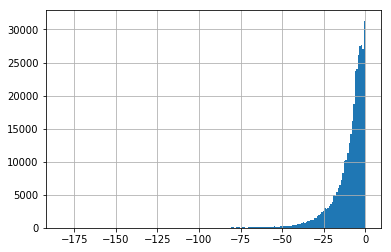

In [38]:
profit_df['max_sell'].hist(bins=200)

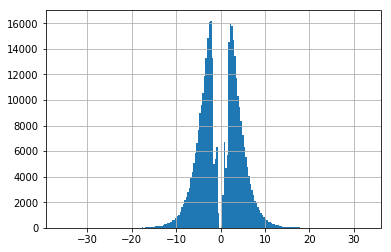

In [39]:
profit_df['score'].hist(bins=200)

In [1]:
# get is_profit
take_profit = 7
stop_loss = 5
buy_df = profit_df[profit_df['score'] > 0]
buy_df['is_profit'] = ((buy_df['max_sell'] > -1 * stop_loss) &
                       (buy_df['max_buy'] > take_profit))
sell_df = profit_df[profit_df['score'] < 0]
sell_df['is_profit'] = ((sell_df['max_buy'] < stop_loss) &
                        (sell_df['max_sell'] < -1 * take_profit))
sell_df.head()

NameError: name 'profit_df' is not defined

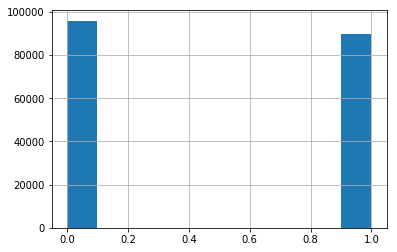

In [67]:
# check percent of is_profit
buy_df['is_profit'].hist()

Win = 95929
Lose = 89993


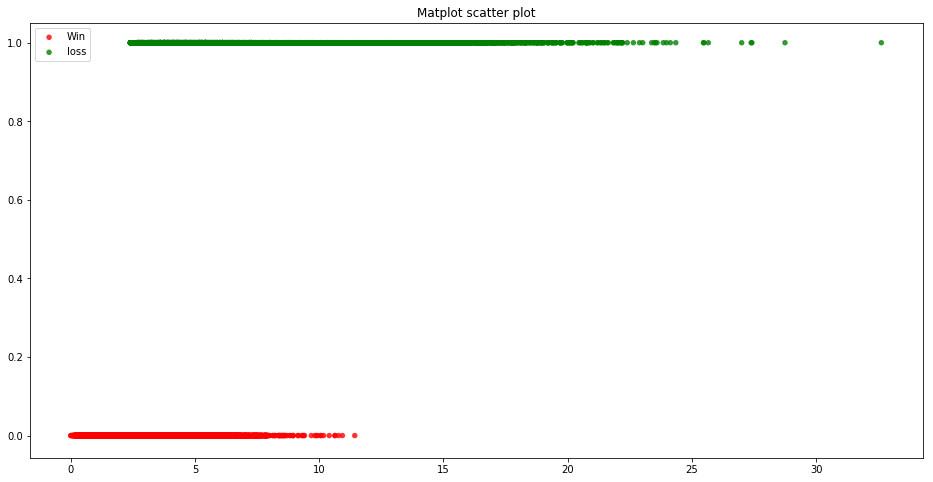

In [66]:
# scatter for score and is_profit

data = ( buy_df[buy_df['is_profit']==False],buy_df[buy_df['is_profit']==True])
print(f'Lose = {len(data[0])}')
print(f'Win = {len(data[1])}')

colors = ("red", "green")
groups = ("Win", "loss")
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 1, 1)

for d, color, group in zip(data, colors, groups):
    ax.scatter(d.score, d.is_profit, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Matplot scatter plot')
plt.legend(loc=2)
plt.show()

In [83]:
# check which value is a good threshold for profit or not
for threshold in range(10):
    print(f'threshold = {threshold}')
    print(buy_df[buy_df['score']>threshold]['is_profit'].value_counts(normalize=True)*100)

threshold = 0
False    51.596368
True     48.403632
Name: is_profit, dtype: float64
threshold = 1
True     50.627549
False    49.372451
Name: is_profit, dtype: float64
threshold = 2
True     57.701876
False    42.298124
Name: is_profit, dtype: float64
threshold = 3
True     76.860052
False    23.139948
Name: is_profit, dtype: float64
threshold = 4
True     87.770764
False    12.229236
Name: is_profit, dtype: float64
threshold = 5
True     94.735206
False     5.264794
Name: is_profit, dtype: float64
threshold = 6
True     97.255436
False     2.744564
Name: is_profit, dtype: float64
threshold = 7
True     98.613811
False     1.386189
Name: is_profit, dtype: float64
threshold = 8
True     99.635775
False     0.364225
Name: is_profit, dtype: float64
threshold = 9
True     99.751276
False     0.248724
Name: is_profit, dtype: float64


In [85]:
for threshold in range(10):
    print(f'threshold = {threshold}')
    print(sell_df[sell_df['score']<-1*threshold]['is_profit'].value_counts(normalize=True)*100)

threshold = 0
False    51.95603
True     48.04397
Name: is_profit, dtype: float64
threshold = 1
True     50.072917
False    49.927083
Name: is_profit, dtype: float64
threshold = 2
True     57.174394
False    42.825606
Name: is_profit, dtype: float64
threshold = 3
True     76.302234
False    23.697766
Name: is_profit, dtype: float64
threshold = 4
True     87.322389
False    12.677611
Name: is_profit, dtype: float64
threshold = 5
True     94.38708
False     5.61292
Name: is_profit, dtype: float64
threshold = 6
True     96.814799
False     3.185201
Name: is_profit, dtype: float64
threshold = 7
True     98.575485
False     1.424515
Name: is_profit, dtype: float64
threshold = 8
True     99.537213
False     0.462787
Name: is_profit, dtype: float64
threshold = 9
True     99.725275
False     0.274725
Name: is_profit, dtype: float64


### Conclusion
For fixed TP=7 and SL=5

**Score = 4 is a good threshold, >4 to buy, <-4 to sell**

# Evaluate score

In [59]:
merge_df.score.describe()

count    374503.000000
mean         -0.053220
std           4.688687
min         -35.990910
25%          -3.486350
50%          -0.662090
75%           3.415940
max          32.628290
Name: score, dtype: float64

In [71]:
# scalping hours
merge_df[(merge_df['hour'] > 18) & (merge_df['hour'] < 23)]['score'].describe()

count    62130.000000
mean         0.179759
std          3.935640
min        -35.413290
25%         -2.805850
50%          0.747240
75%          3.154340
max         23.851250
Name: score, dtype: float64

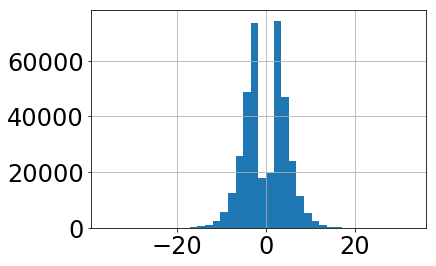

In [61]:
merge_df['score'].hist(bins=40)

In [78]:
total_count=len(merge_df[(merge_df['hour'] > 18) & (merge_df['hour'] < 23)])
scalping_count=len(merge_df[(merge_df['hour'] > 18) & (merge_df['hour'] < 23) & (merge_df['score'] > 4)])

print('Percentage: %s/%s = %.3f'%(scalping_count,total_count,scalping_count/total_count))

merge_df[(merge_df['hour'] > 18) & (merge_df['hour'] < 23) &
         (merge_df['score'] > 4) & (merge_df['score'] < 10)].head()

Percentage: 10006/62130 = 0.161


,open,high,low,close,volume,hour,volatility,macd,macdsignal,macdhist,rsi,max_buy,max_buy_count,max_sell,max_sell_count,score
time,,,,,,,,,,,,,,,,
2018-02-01 19:00:00,1.42538,1.42538,1.42518,1.42519,211.94,19,2.0,0.000296,0.000268,0.000028,60.006389,19.2,60,-1.1,6,6.66841
2018-02-01 19:01:00,1.42519,1.42520,1.42511,1.42520,130.73,19,0.9,0.000283,0.000271,0.000012,60.200185,19.1,60,-1.2,6,6.45415
2018-02-01 19:02:00,1.42518,1.42530,1.42509,1.42530,135.12,19,2.1,0.000277,0.000273,0.000005,62.174103,18.1,57,-2.2,9,5.10763
2018-02-01 19:10:00,1.42571,1.42572,1.42523,1.42542,246.30,19,4.9,0.000312,0.000329,-0.000016,53.968989,21.0,55,-3.4,8,4.71002
2018-02-01 19:12:00,1.42512,1.42534,1.42510,1.42525,188.74,19,2.4,0.000213,0.000293,-0.000081,50.164505,22.7,60,-1.7,5,6.20180


# Create feature

Name 	           Value
RSI(14) 			63.841
STOCH(9,6) 			46.092
STOCHRSI(14) 		17.633
MACD(12,26) 		0.001
ADX(14) 			45.939
Williams %R 		-27.77
CCI(14) 			96.681
ATR(14) 			0.0011
Highs/Lows(14) 		0.0000
Ultimate Oscillator 55.182
ROC 				0.103

Here we use MACD and RSI indicator as feature

In [7]:
test_df['macd'], test_df['macdsignal'], test_df['macdhist'] = ta.MACD(test_df['close'],
                                     fastperiod=12,
                                     slowperiod=26,
                                     signalperiod=9)
test_df['rsi']= ta.RSI(test_df['close'], timeperiod=14)

df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['close'],
                                     fastperiod=12,
                                     slowperiod=26,
                                     signalperiod=9)
df['rsi']= ta.RSI(df['close'], timeperiod=14)
df.tail(5)

,open,high,low,close,volume,hour,volatility,macd,macdsignal,macdhist,rsi
time,,,,,,,,,,,
2019-02-01 21:55:00,1.30773,1.30799,1.30773,1.30796,91.58,21,2.6,-0.000138,-0.000052,-0.000087,39.834582
2019-02-01 21:56:00,1.30797,1.30844,1.30796,1.30842,66.66,21,4.8,-0.000102,-0.000062,-0.000040,55.248318
2019-02-01 21:57:00,1.30843,1.30857,1.30835,1.30835,94.78,21,2.2,-0.000078,-0.000065,-0.000013,53.022223
2019-02-01 21:58:00,1.30836,1.30859,1.30790,1.30815,173.23,21,6.9,-0.000074,-0.000067,-0.000007,47.173758
2019-02-01 21:59:00,1.30816,1.30839,1.30803,1.30839,45.15,21,3.6,-0.000051,-0.000063,0.000013,53.764382


In [8]:
# concat with max profit and score
# remove head tail which Nan value
test_merge_df = pd.merge(test_df, test_profit_df, on='time')
test_merge_df.drop(test_merge_df.tail(60).index,inplace=True)
test_merge_df.drop(test_merge_df.head(33).index,inplace=True)

merge_df = pd.merge(df, profit_df, on='time')
merge_df.drop(merge_df.tail(60).index,inplace=True)
merge_df.drop(merge_df.head(33).index,inplace=True)

merge_df.head(5)

,open,high,low,close,volume,hour,volatility,macd,macdsignal,macdhist,rsi,max_buy,max_buy_count,max_sell,max_sell_count,score
time,,,,,,,,,,,,,,,,
2018-02-01 00:33:00,1.42051,1.42051,1.42043,1.42049,61.04,0,0.8,0.000013,0.000110,-0.000097,48.790187,3.3,12,-18.8,55,-4.51350
2018-02-01 00:34:00,1.42049,1.42070,1.42048,1.42070,87.16,0,2.2,0.000019,0.000092,-0.000072,55.262985,1.2,6,-20.9,59,-6.72793
2018-02-01 00:35:00,1.42071,1.42071,1.42059,1.42059,78.07,0,1.2,0.000016,0.000076,-0.000061,51.584918,2.3,5,-19.8,57,-5.24580
2018-02-01 00:36:00,1.42059,1.42071,1.42059,1.42071,83.39,0,1.2,0.000022,0.000066,-0.000043,55.096019,1.1,4,-21.0,59,-6.94966
2018-02-01 00:37:00,1.42071,1.42082,1.42071,1.42078,144.90,0,1.1,0.000033,0.000059,-0.000026,57.052614,0.4,2,-21.7,60,-10.16588


# Visualize Feature and score

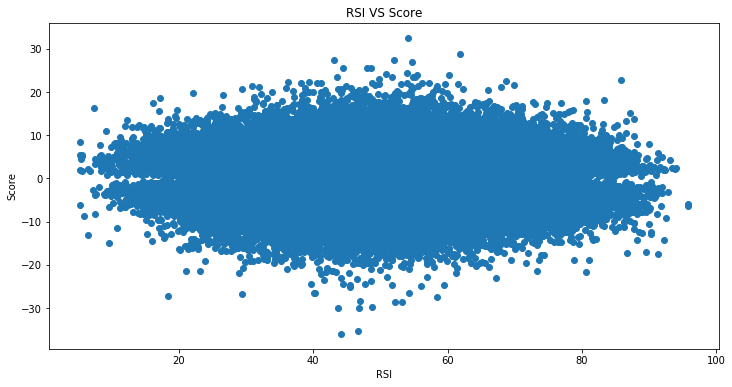

In [21]:
figsize(12, 6)
plt.scatter(merge_df['rsi'], merge_df['score'])
plt.title("RSI VS Score")
plt.ylabel("Score")
plt.xlabel("RSI")
plt.show()

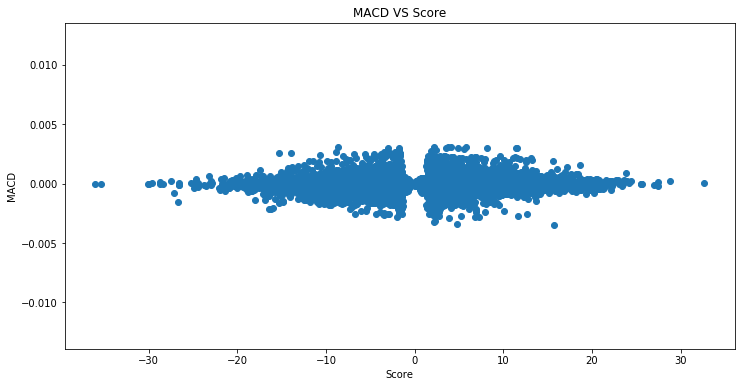

In [22]:
figsize(12, 6)
plt.scatter(merge_df['score'],merge_df['macd'])
plt.title("MACD VS Score")
plt.ylabel("MACD")
plt.xlabel("Score")
plt.show()

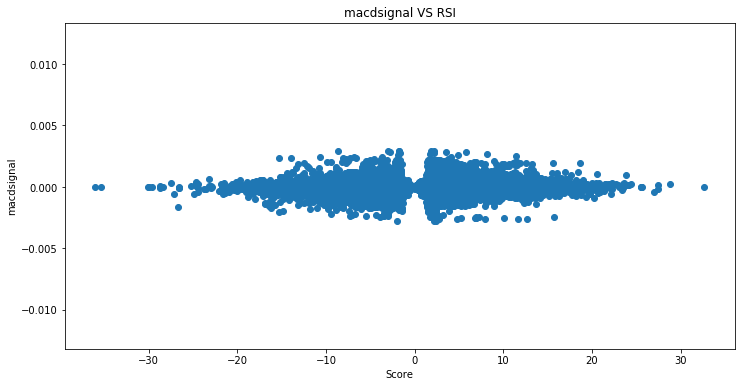

In [23]:
figsize(12, 6)
plt.scatter(merge_df['score'],merge_df['macdsignal'])
plt.title("macdsignal VS Score")
plt.ylabel("macdsignal")
plt.xlabel("Score")
plt.show()

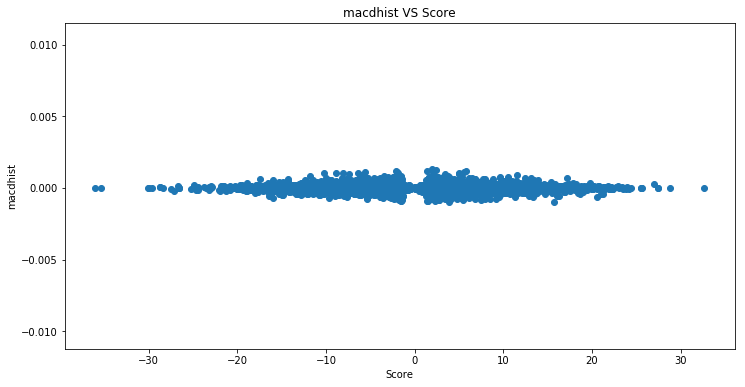

In [25]:
figsize(12, 6)
plt.scatter(merge_df['score'], merge_df['macdhist'])
plt.title("macdhist VS Score")
plt.ylabel("macdhist")
plt.xlabel("Score")
plt.show()

# Save to file

In [55]:
merge_df.to_csv(
    'data/GBPUSD_Candlestick_1_M_ASK_01.02.2018-01.02.2019_featured.csv',
    float_format='%.5f')
test_merge_df.to_csv(
    'data/GBPUSD_Candlestick_1_M_ASK_01.02.2019-24.04.2019_featured.csv',
    float_format='%.5f')